# Exact Heston Model Simuations for Characteristic Function Methods


In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.special as ss
from scipy.stats import norm
from scipy.integrate import trapezoid
import pandas as pd

from utils import (
    cos_cdf,
    cos_pdf,
    carr_madan_cdf,
    carr_madan_pdf,
    conv_pdf,
    conv_cdf,
    CDF_Inverter,
    CIR_Sample,
    ChFIntegratedVariance,
    GeneratePathsHestonES,
    compare_cdf_inversion_methods,
    cdf_inversion_newton,
)

In [2]:
from scipy.optimize import newton

def implied_volatility(C, S, K, r, T, sigma_init=0.2):
    """
    Calculate implied volatility using Newton-Raphson method.
    
    Parameters:
    C (float): Market price of call option
    S (float): Current stock price
    K (float): Strike price
    r (float): Risk-free interest rate
    T (float): Time to expiration (in years)
    sigma_init (float): Initial volatility guess
    
    Returns:
    float: Implied volatility
    """
    def objective(sigma):
        return (black_scholes_call(S, K, r, sigma, T) - C)**2
    
    implied_vol = newton(objective, sigma_init)
    return implied_vol


=== Testing COS Method ===
Using cos method for CDF recovery and inversion
Computation time: 0.143 seconds

=== Testing CARR_MADAN Method ===
Using carr_madan method for CDF recovery and inversion
Computation time: 1.694 seconds

=== Testing CONV Method ===
Using conv method for CDF recovery and inversion
Computation time: 10.166 seconds


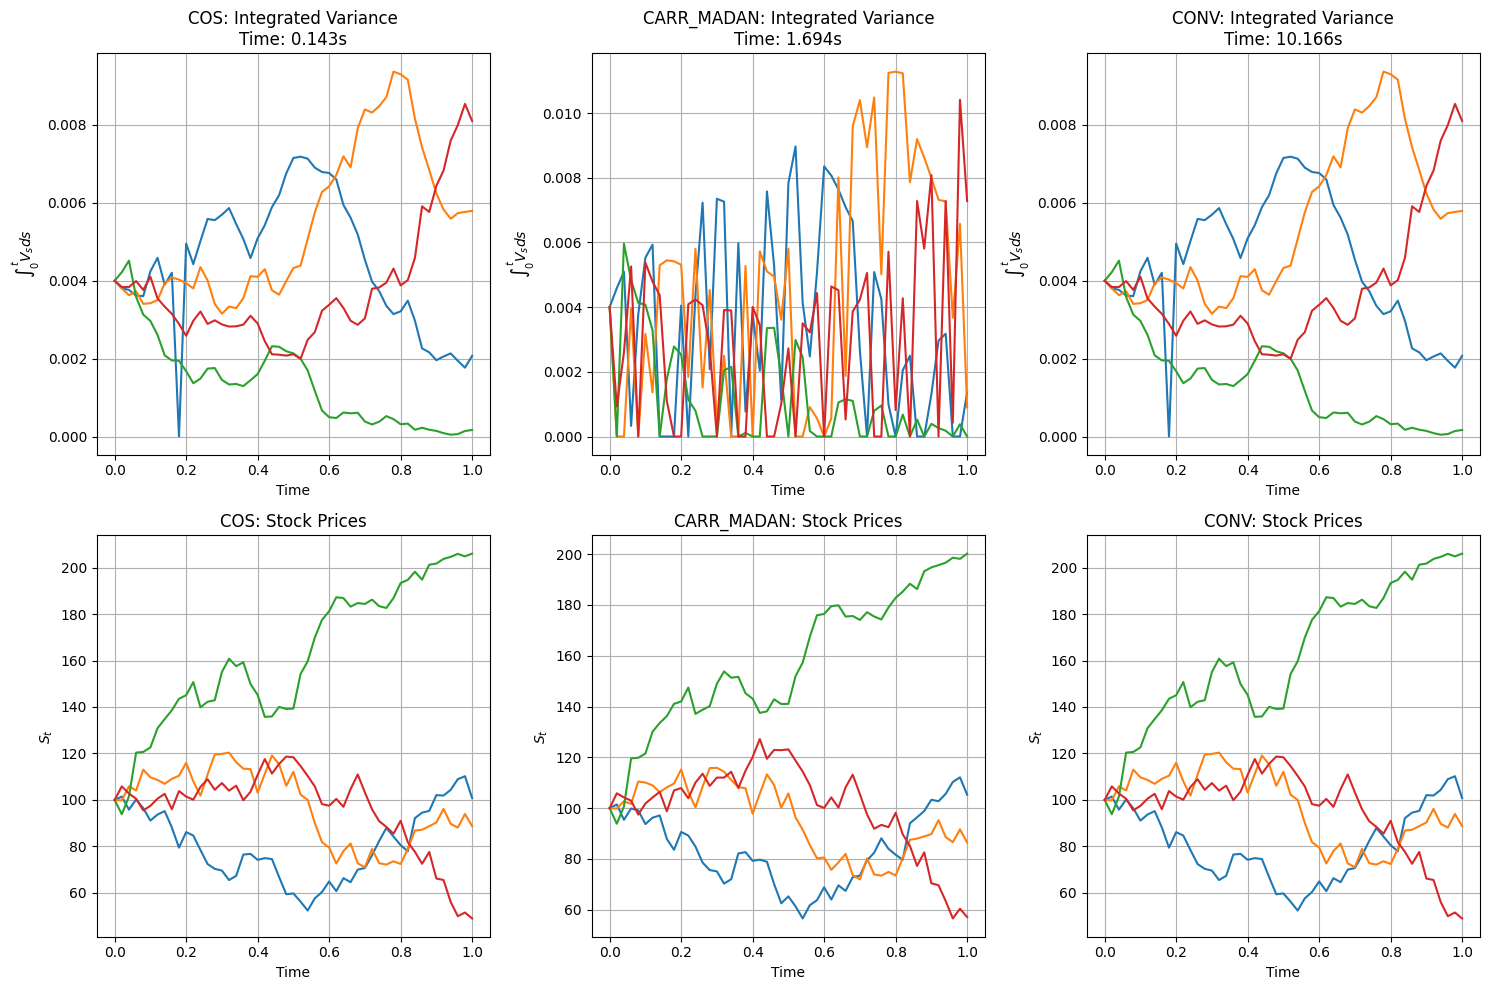


=== Performance Comparison ===
COS: 0.143 seconds
CARR_MADAN: 1.694 seconds
CONV: 10.166 seconds


In [3]:
if __name__ == "__main__":
    # Parameters
    NoOfPaths = 4
    NoOfSteps = 50

    
    # Heston model parameters
    gamma = 0.4 # vol of vol
    kappa = 0.5 # speed of mean reversion
    vbar = 0.2 # long-term mean
    rho = -0.9 # negative correlation
    v0 = 0.2 # initial variance
    T = 1.0
    S_0 = 100.0
    r = 0.1
    
    nr_expansion = 100
    L = 10
    
    # Set random seed for reproducibility
    np.random.seed(3)
    
    # Test all three methods
    methods_to_test = {
        "cos": {},
        "carr_madan": {"N": 2**12},
        "conv": {"alpha": 0.5, "N": 2**13}
    }
    
    results = {}
    
    for method_name, kwargs in methods_to_test.items():
        print(f"\n=== Testing {method_name.upper()} Method ===")
        
        # Reset random seed to ensure fair comparison
        np.random.seed(3)
        
        start_time = time.time()
        paths = GeneratePathsHestonES(
            NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0,
            nr_expansion=nr_expansion, L=L, recovery_method=method_name, **kwargs
        )
        end_time = time.time()
        
        results[method_name] = {
            "paths": paths,
            "computation_time": end_time - start_time
        }
        
        print(f"Computation time: {end_time - start_time:.3f} seconds")
    
    # Plot comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for idx, (method_name, result) in enumerate(results.items()):
        timeGrid = result["paths"]["time"]
        S = result["paths"]["S"]
        V_int = result["paths"]["Vint"]
        
        # Plot integrated variance
        axes[0, idx].grid(True)
        axes[0, idx].plot(timeGrid, np.transpose(V_int))
        axes[0, idx].set_xlabel('Time')
        axes[0, idx].set_ylabel(r'$\int_0^t V_s ds$')
        axes[0, idx].set_title(f'{method_name.upper()}: Integrated Variance\nTime: {result["computation_time"]:.3f}s')
        
        # Plot stock price paths
        axes[1, idx].grid(True)
        axes[1, idx].plot(timeGrid, np.transpose(S))
        axes[1, idx].set_xlabel('Time')
        axes[1, idx].set_ylabel(r'$S_t$')
        axes[1, idx].set_title(f'{method_name.upper()}: Stock Prices')
    
    plt.tight_layout()
    plt.show()
    
    # Print timing comparison
    print("\n=== Performance Comparison ===")
    for method_name, result in results.items():
        print(f"{method_name.upper()}: {result['computation_time']:.3f} seconds")


## Observations
1 Comparison:
- COS method is the fastest - avoids using integration, most stable.
- Carr-Madan method seems unstable due to stability issues likely due to very small values when inverting CDF (even if increase u_max=500, N=2**14).
- CONV method is the slowest due to expensive convolution operations.


2 Stock Prices: 
- Each method produces similar final stock price paths, indicating that when the methods work correctly, they converge to the same distributional behavior.


3. Integrated Variance Process Issues with Carr-Madan
- Root cause: The Carr-Madan method produces zeros in the integrated variance process due to numerical breakdown in the CDF inversion:
    - PDF computation failures: compute_pdf() returns near-zero or negative values, causing Newton's method to take unstable steps.
    - CDF monotonicity violations: compute_cdf() may be non-monotonic or numerically flat near zero, leading the initial guess selection to converge toward the boundary.
    - Cascading numerical errors: When PDF ≈ 0, Newton's step x_new = x - f(x)/f'(x) becomes undefined or explosive.
4. Could we fix it?
    - Could we have used bisection? Yes, but that would be significantly slower.
    - Could we use bisection to get the first initial guess and then switch to Newton? Yes.
    - But the key issue is that `compute_pdf()` returns near-zero velues, which will break any Newton-type method/procedure.
Why other methods avoid this:

- COS method: Built-in domain truncation [a,b] prevents boundary violations and maintains numerical stability through bounded Fourier series.
- CONV method: FFT-based approach with proper normalization and damping parameters provides inherent regularization.

Consequence:
- Only Carr-Madan exhibits integrated variance hitting zero because its unbounded domain integration makes it susceptible to tail approximation errors that destabilize the Newton iteration.
    



#### COS method is the winner
Use cases: 
- Option Pricing: replacing the Monte Carlo with COS method.
- Model Calibration: Can be used to fit Heston parameters.
- Trading Systems: Enables fast Greeks and sensitivity analysis.
- Real-time Risk Management: Very fast calculations of VaR.

#### Newton-Raphson method vs. brute force approach for CDF inversion

/Users/patrikliba/QFB/utils.py:276: RuntimeWarning: invalid value encountered in scalar multiply
  chf = temp1 * temp2 * temp3 / temp4
/Users/patrikliba/QFB/utils.py:276: RuntimeWarning: invalid value encountered in scalar divide
  chf = temp1 * temp2 * temp3 / temp4
/Users/patrikliba/QFB/utils.py:263: RuntimeWarning: invalid value encountered in divide
  temp1 = R * np.exp(-tau / 2.0 * (R - kappa)) * (1 - np.exp(-kappa * tau)) / (kappa * (1 - np.exp(-R * tau)))
/Users/patrikliba/QFB/utils.py:266: RuntimeWarning: invalid value encountered in divide
  kappa * (1 + np.exp(-kappa * tau)) / (1 - np.exp(-kappa * tau)) - R * (1 + np.exp(-R * tau)) / (
/Users/patrikliba/QFB/utils.py:271: RuntimeWarning: invalid value encountered in divide
  np.sqrt(vt * vu) * 4.0 * R * np.exp(-R * tau / 2.0) / (gamma ** 2 * (1 - np.exp(-R * tau))))


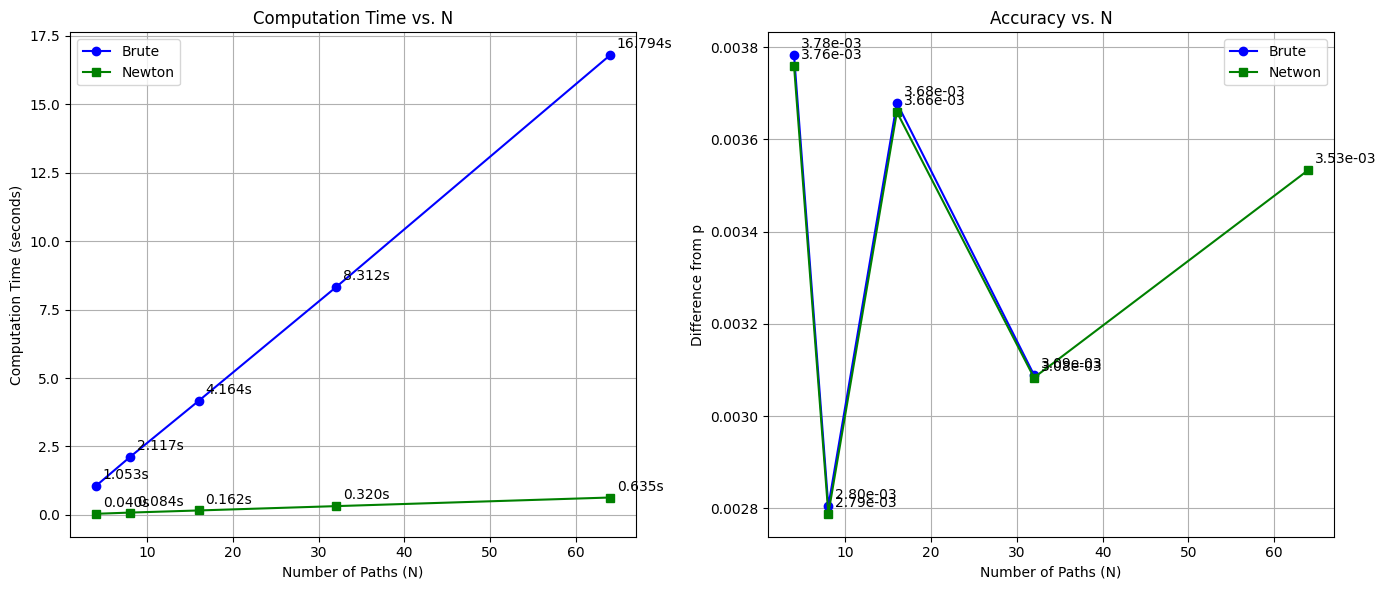

,N,Brute Time (s),Newton Time (s),vint_brute_values,vint_newton_values
0,4,1.052851,0.040360,0.003782,0.003759
1,8,2.116921,0.084473,0.002805,0.002788
2,16,4.164161,0.162329,0.003679,0.003659
3,32,8.311904,0.320097,0.003089,0.003083
4,64,16.793657,0.635020,NaN,0.003533


In [7]:
# RuntimeWarning is due to division by a number very close to 0
compare_cdf_inversion_methods()